<img align="right" width="400" src="https://www.fhnw.ch/de/++theme++web16theme/assets/media/img/fachhochschule-nordwestschweiz-fhnw-logo.svg" alt="FHNW Logo">


# Simple Transformer Text Classifier

by Fabian Märki

## Summary
The aim of this notebook is to use [Simple Transformer](https://simpletransformers.ai) and fine tune a text classifier (using Transformer models has never been *simpler*). 

## Links
- https://simpletransformers.ai/docs/classification-specifics/
- https://simpletransformers.ai/docs/classification-models
- https://simpletransformers.ai/docs/binary-classification/

## Further Steps
- Use [Huggingfase's Transformers](https://huggingface.co/) directly [nice how-to](https://huggingface.co/course/chapter1)
- Use a [Transformer model as embedding layer and fine tune on TPU](https://towardsdatascience.com/hugging-face-transformers-fine-tuning-distilbert-for-binary-classification-tasks-490f1d192379)


## Docker
In case you use docker make sure to increase shared memory size (e.g. by adding the flag *--shm-size 2gb*)

<a href="https://colab.research.google.com/github/markif/2021_HS_DAS_NLP_Notebooks/blob/master/08_a_SimpleTransformer_Text_Classifier_FineTuning.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
!pip install 'fhnw-nlp-utils>=0.1.6'

from fhnw.nlp.utils.storage import load_dataframe
from fhnw.nlp.utils.storage import download

import numpy as np
import pandas as pd

import tensorflow as tf

print("Tensorflow version:", tf.__version__)

#physical_devices = tf.config.list_physical_devices('GPU') 
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

  Attempting uninstall: fhnw-nlp-utils
    Found existing installation: fhnw-nlp-utils 0.1.3
    Uninstalling fhnw-nlp-utils-0.1.3:
      Successfully uninstalled fhnw-nlp-utils-0.1.3
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Tensorflow version: 2.5.1
GPU is available


In [2]:
%%time
download("https://drive.google.com/uc?id=19AFeVnOfX8WXU4_3rM7OFoNTWWog_sb_", "data/german_doctor_reviews_tokenized.parq")
data = load_dataframe("data/german_doctor_reviews_tokenized.parq")

download("https://drive.google.com/uc?id=1tT2dj70GLi2bJYg4j3g1MIglGXTDAugI", "data/german_doctor_reviews_augmented_tokenized.parq")
data_aug = load_dataframe("data/german_doctor_reviews_augmented_tokenized.parq")

CPU times: user 12.5 s, sys: 2.1 s, total: 14.6 s
Wall time: 8.05 s


In [3]:
# remove all neutral sentimens
data = data.loc[(data["label"] != "neutral")]
data.shape

(331187, 10)

In [4]:
data.head(3)

,text_original,rating,text,label,sentiment,token_clean,text_clean,token_lemma,token_stem,token_clean_stopwords
0,Ich bin franzose und bin seit ein paar Wochen ...,2.0,Ich bin franzose und bin seit ein paar Wochen ...,positive,1,"[ich, bin, franzose, und, bin, seit, ein, paar...",ich bin franzose und bin seit ein paar wochen ...,"[franzose, seit, paar, wochen, muenchen, zahn,...","[franzos, seit, paar, woch, muench, ., zahn, s...","[franzose, seit, paar, wochen, muenchen, ., za..."
1,Dieser Arzt ist das unmöglichste was mir in me...,6.0,Dieser Arzt ist das unmöglichste was mir in me...,negative,-1,"[dieser, arzt, ist, das, unmöglichste, was, mi...",dieser arzt ist das unmöglichste was mir in me...,"[arzt, unmöglichste, leben, je, begegnen, unfr...","[arzt, unmog, leb, je, begegnet, unfreund, ,, ...","[arzt, unmöglichste, leben, je, begegnet, unfr..."
2,Hatte akute Beschwerden am Rücken. Herr Magura...,1.0,Hatte akute Beschwerden am Rücken. Herr Magura...,positive,1,"[hatte, akute, beschwerden, am, rücken, ., her...",hatte akute beschwerden am rücken . herr magur...,"[akut, beschwerden, rücken, magura, erste, arz...","[akut, beschwerd, ruck, ., magura, erst, arzt,...","[akute, beschwerden, rücken, ., magura, erste,..."


In [5]:
data_aug.head(3)

,text_original,rating,label,sentiment,text,token_clean,text_clean,token_lemma,token_stem,token_clean_stopwords
0,Dieser Arzt ist das unmöglichste was mir in me...,6.0,negative,-1,"dieser arzt ist das unmöglichste, das ich je i...","[dieser, arzt, ist, das, unmöglichste, ,, das,...","dieser arzt ist das unmöglichste , das ich je ...","[arzt, unmöglichste, je, leben, triefen, böswi...","[arzt, unmog, ,, je, leb, getroff, ,, boswill,...","[arzt, unmöglichste, ,, je, leben, getroffen, ..."
1,Dieser Arzt ist das unmöglichste was mir in me...,6.0,negative,-1,"dieser arzt ist das unmöglichste, was ich jema...","[dieser, arzt, ist, das, unmöglichste, ,, was,...","dieser arzt ist das unmöglichste , was ich jem...","[arzt, unmöglichste, jemals, leben, kennen, ve...","[arzt, unmog, ,, jemal, leb, kannt, ,, versaut...","[arzt, unmöglichste, ,, jemals, leben, kannte,..."
2,Dieser Arzt ist das unmöglichste was mir in me...,6.0,negative,-1,dieser arzt ist am wenigsten unmöglich in mein...,"[dieser, arzt, ist, am, wenigsten, unmöglich, ...",dieser arzt ist am wenigsten unmöglich in mein...,"[arzt, wenig, unmöglich, leben, finden, unfreu...","[arzt, wenig, unmog, leb, find, ,, unfreund, ,...","[arzt, wenigsten, unmöglich, leben, finden, ,,..."


In [6]:
!pip install simpletransformers

     |████████████████████████████████| 82 kB 976 kB/s eta 0:00:01


  Attempting uninstall: click
    Found existing installation: click 8.0.1
    Uninstalling click-8.0.1:
      Successfully uninstalled click-8.0.1
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [1]:
# Activate for faster training
#data = data.head(5000)

In [23]:
params = {
    "verbose": True,
    "batch_size": 64,
    #"X_column_name": "text_clean",
    "X_column_name": "text",
    "y_column_name": "label",
}

In [24]:
def create_simple_transformer_classification_model_and_set(params, data):

    from fhnw.nlp.utils.params import get_classification_type
    from fhnw.nlp.utils.system import get_gpu_device_number
    
    computed_objects_column_name = params.get("computed_objects_column_name", "computed_objects")
    transformer_model_type = params.get("transformer_model_type", "distilbert")
    transformer_model_name = params.get("transformer_model_name", "distilbert-base-multilingual-cased")
    transformer_dropout = params.get("transformer_dropout", 0.3)
    transformer_attention_dropout = params.get("transformer_attention_dropout", 0.3)
    y_column_name = params.get("y_column_name", "label")
    
    gpu_device_nr = get_gpu_device_number()
    classification_type = get_classification_type(params, data)
    
    if classification_type == "multi-label":
        from simpletransformers.classification import MultiLabelClassificationArgs
            
        model_args = MultiLabelClassificationArgs()
    else:
        from simpletransformers.classification import ClassificationArgs
            
        model_args = ClassificationArgs()

    #model_args.use_early_stopping = True
    #model_args.early_stopping_delta = 0.01
    #model_args.early_stopping_metric = "mcc"
    #model_args.early_stopping_metric_minimize = False
    #model_args.early_stopping_patience = 5

    #model_args.evaluate_during_training = True
    #model_args.evaluate_during_training_steps = 1000

    model_args.num_train_epochs = params.get("training_epochs", 3)
    model_args.learning_rate = params.get("learning_rate", 4e-5)
    model_args.train_batch_size=params.get("batch_size", 64)
    model_args.eval_batch_size=model_args.train_batch_size
    model_args.labels_list = list(data[y_column_name].unique())
    # these might change depending on the model (these are for distilbert)
    # without increasing dropout the model severely overfits 
    # see plots at the end which are from a run with default dropout
    model_args.config = {"dropout": transformer_dropout,
                         "attention_dropout": transformer_attention_dropout,
                         "seq_classif_dropout": transformer_dropout,
                        }


    if classification_type == "multi-label":
        from simpletransformers.classification import MultiLabelClassificationModel
            
        transformer_model = MultiLabelClassificationModel(transformer_model_type, 
                                    transformer_model_name, 
                                    use_cuda=gpu_device_nr != -1, 
                                    cuda_device=gpu_device_nr, 
                                    args=model_args)
    else:
        from simpletransformers.classification import ClassificationModel
            
        transformer_model = ClassificationModel(transformer_model_type, 
                                    transformer_model_name, 
                                    use_cuda=gpu_device_nr != -1, 
                                    cuda_device=gpu_device_nr, 
                                    args=model_args)
    
    params.setdefault(computed_objects_column_name, {})["simple_transformer_model"] = transformer_model

In [25]:
create_simple_transformer_classification_model_and_set(params, data)

Inferred classification type: binary


Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'pre_classif

In [26]:
from sklearn.model_selection import train_test_split

y_column_name = params.get("y_column_name", "label")

data_train, data_test = train_test_split(data, shuffle=True, random_state=42, stratify=data[y_column_name])
#data_train = pd.concat([data_train, data_aug])
data_train, data_val = train_test_split(data_train, shuffle=True, random_state=42, stratify=data_train[y_column_name])

In [27]:
import logging

logging.basicConfig(level=logging.WARNING)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [28]:
X_column_name = params.get("X_column_name", "text_clean")
y_column_name = params.get("y_column_name", "label")

data_train = data_train.drop(data_train.columns.difference([X_column_name, y_column_name]), 1)
data_test = data_test.drop(data_test.columns.difference([X_column_name, y_column_name]), 1)
data_val = data_val.drop(data_val.columns.difference([X_column_name, y_column_name]), 1)

data_train = data_train.rename(columns={y_column_name: "labels"}, errors='ignore')
data_test = data_test.rename(columns={y_column_name: "labels"}, errors='ignore')
data_val = data_val.rename(columns={y_column_name: "labels"}, errors='ignore')

params["y_column_name"] = "labels"

In [29]:
from shutil import rmtree

rmtree("outputs", ignore_errors=True)

In [30]:
%%time

computed_objects_column_name = params.get("computed_objects_column_name", "computed_objects")
model = params[computed_objects_column_name]["simple_transformer_model"]

model.train_model(train_df=data_train, eval_df=data_val)

  0%|          | 0/186292 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/2911 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:942: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  model.parameters(), args.max_grad_norm


Running Epoch 1 of 5:   0%|          | 0/2911 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/2911 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/2911 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/2911 [00:00<?, ?it/s]

CPU times: user 1h 4min 48s, sys: 26.2 s, total: 1h 5min 14s
Wall time: 1h 5min 22s


(14555, 0.04063451412165546)

In [31]:
#model.eval_model(eval_df=data_test)

In [32]:
def report_classification_results(params, y, y_pred):
    """Reports all classification results

    Parameters: 
        params: dict
            The dictionary containing the parameters
        y: list
            The true labels
        y_pred: list
            The predicted labels
    """
    
    import os
    from sklearn.metrics import classification_report
    from fhnw.nlp.utils.ploting import plot_confusion_matrix
    
    verbose = params.get("verbose", False)
    path = params.get("model_path")
    
    if path is not None:
        path_confusion_matrix = os.path.join(path, "confusion_matrix.png")
        plot_confusion_matrix(y, y_pred, filename=path_confusion_matrix)
    if verbose:
        plot_confusion_matrix(y, y_pred)
        
    if path is not None:
        path_classification_report = os.path.join(path, "classification_report.csv")
        report = classification_report(y, y_pred, output_dict=True)
        report = pandas.DataFrame(report).transpose()
        report.to_csv(path_classification_report)
    if verbose:
        report = classification_report(y, y_pred)
        print(report)

In [33]:
X_column_name = params.get("X_column_name", "text_clean")
y_column_name = params.get("y_column_name", "labels")

y_pred = model.predict(data_test[X_column_name].to_list())[0]

  0%|          | 0/82797 [00:00<?, ?it/s]

  0%|          | 0/1294 [00:00<?, ?it/s]

Check performance on all data.

**Note:** This time the model was trained with the original data (no data augmentation) and on the *text* column (with cleaning but without text normalization).

Set Population: 82797
Accuracy: 0.9804


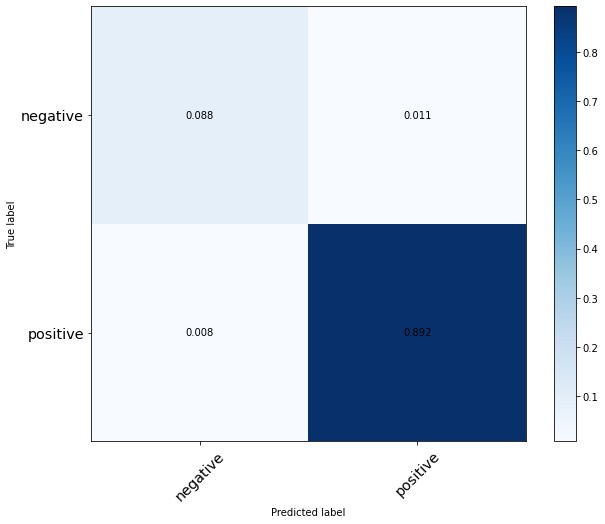

              precision    recall  f1-score   support

    negative       0.92      0.89      0.90      8256
    positive       0.99      0.99      0.99     74541

    accuracy                           0.98     82797
   macro avg       0.95      0.94      0.94     82797
weighted avg       0.98      0.98      0.98     82797



In [34]:
report_classification_results(params, data_test["labels"].to_list(), y_pred)

In [35]:
y_pred = model.predict(data_train[X_column_name].to_list())[0]

  0%|          | 0/186292 [00:00<?, ?it/s]

  0%|          | 0/2911 [00:00<?, ?it/s]

Set Population: 186292
Accuracy: 0.9994


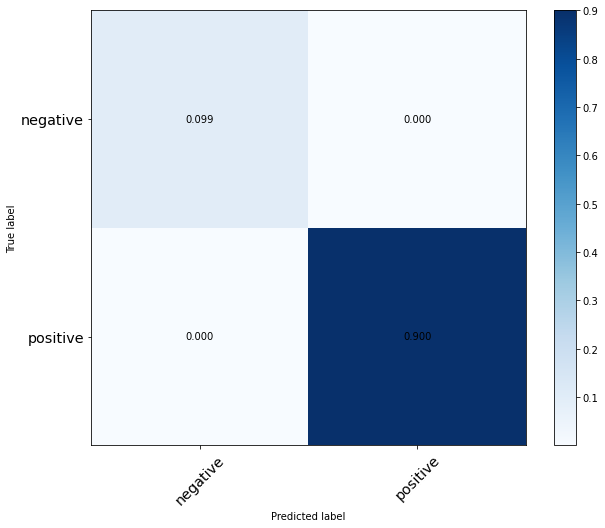

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00     18574
    positive       1.00      1.00      1.00    167718

    accuracy                           1.00    186292
   macro avg       1.00      1.00      1.00    186292
weighted avg       1.00      1.00      1.00    186292



In [36]:
report_classification_results(params, data_train["labels"].to_list(), y_pred)

In [37]:
y_pred = model.predict(data_val[X_column_name].to_list())[0]

  0%|          | 0/62098 [00:00<?, ?it/s]

  0%|          | 0/971 [00:00<?, ?it/s]

Set Population: 62098
Accuracy: 0.9795


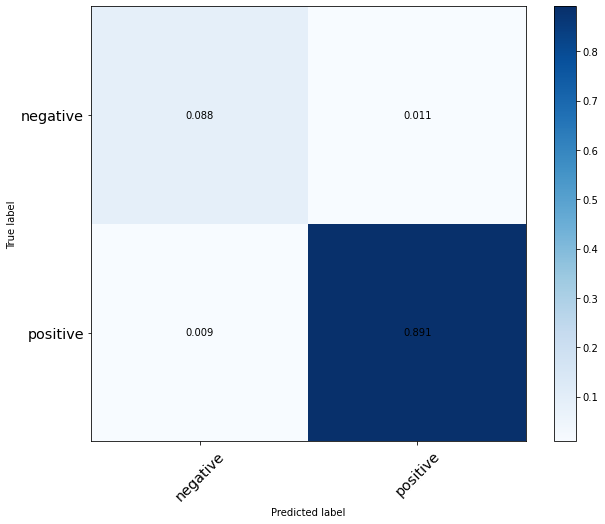

              precision    recall  f1-score   support

    negative       0.91      0.88      0.90      6192
    positive       0.99      0.99      0.99     55906

    accuracy                           0.98     62098
   macro avg       0.95      0.94      0.94     62098
weighted avg       0.98      0.98      0.98     62098



In [38]:
report_classification_results(params, data_val["labels"].to_list(), y_pred)